In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import arff as ar
import os

In [28]:
np.random.seed(1)

# the factor ot the standard deviation of the error
std_coef = 0.1

# Mean of the normal distributed error
mean = 0

# If the dataset is dedicated to the DUST distance. if True, the will a different error distribution 
# for each column of the dataset
dust_dedicated = False

In [29]:
dataset_folder = "dataset/Shapelet_ucr"
output_folder = f"dataset/Uncertain_Shapelet_ucr/{str(std_coef).replace('.', '_')}"
all_ds = os.listdir(dataset_folder)

electric_devices = ['PowerCons', 'HouseTwenty']
ecg = ['AtrialFibrillation', 'ECG200', 'StandWalkJump', 'TwoLeadECG', 'ECGFiveDays']
sensor = ['ItalyPowerDemand', 'SonyAIBORobotSurface2', 'SonyAIBORobotSurface1', 'Plane', 
          'Trace'] # 'DodgerLoopWeekend', 'DodgerLoopGame' and 'DodgerLoopDay' contain NaN
simulated = ['SmoothSubspace', 'BME', 'CBF', 'UMD', 'SyntheticControl', 'ShapeletSim']
others = ['Chinatown']
datasets = ecg + sensor + simulated + others
datasets = list(filter(lambda d: d in all_ds, datasets))
print("Nb of datasets:", len(datasets))
print(datasets)

Nb of datasets: 1
['Chinatown']


In [30]:
def load_data(dataset, suffix):
    arff_data = arff.loadarff(f"{dataset_folder}/{dataset}/{dataset}_{suffix}.arff")
    data = pd.DataFrame(data=arff_data[0])
    if 'target' in data.columns:
        data.target = data.target.astype(int)
    else:
        data["class"] = data["class"].astype(int)
    return data

In [74]:
def add_noise(data, std_coef, mean=0):
    std = data[data.columns[:-1]].std(axis=0)
    a = np.zeros(shape=(data.shape[0], data.shape[1] - 1), dtype=np.float32)
    a[:,] = std.values
    std = a.copy()
    
#     ten_per_cent = int(data.shape[0] / 10)
#     std[ten_per_cent: 2*ten_per_cent, :] /= 2 # two time smaller uncertainty here
#     std[2*ten_per_cent:, :] = 0 # no uncertainty here
    
    if not dust_dedicated:
        std = np.random.normal(mean, std, (data.shape[0], data.shape[1] - 1))
        std = np.abs(std)
        
    std *= std_coef
    
    err = np.random.normal(mean, std, size=(data.shape[0], data.shape[1]-1))
    
    u_data = data.copy()
    
    for i, c in enumerate(data.columns[:-1]):
        u_data[c] += err[:, i]
    
    std = pd.DataFrame(data=std, columns=[f"{c}_err" for c in data.columns[:-1]])
    std = std.astype(float).round(3)
    
    return u_data.astype(float).round(3), std

In [32]:
def df_to_arff_dict(dataset_name, data, is_err=False):
    attributes = [(c, 'NUMERIC') for c in data.columns.values]
    if not is_err:
        t = data.columns[-1]
        attributes[-1] = ('target', data[t].unique().astype(str).tolist())
        data[t] = data[t].astype(str)
        
    data = [data.loc[i].values.tolist() for i in range(data.shape[0])]
        
    return {
        'attributes': attributes,
        'data': data,
        'relation': dataset_name,
        'description': ''
    }

In [33]:
def save(dataset, suffix, data, is_noise=False):
    directory = f"{output_folder}/{dataset}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(f"{directory}/{dataset}_{suffix}.arff", "w", encoding="utf8") as f:
        ar.dump(df_to_arff_dict(dataset, data.round(3), is_noise), f)

In [75]:
for dataset in datasets:
    try:
        data_train = load_data(dataset, 'TRAIN')
        data_test = load_data(dataset, 'TEST')      
        
        noised_data_train, noise_std_train = add_noise(data_train, std_coef=std_coef)
        noised_data_test, noise_std_test = add_noise(data_test, std_coef=std_coef)
        
        save(dataset, 'TRAIN', noised_data_train)
        save(dataset, 'TEST', noised_data_test)
        save(dataset, 'NOISE_TRAIN', noise_std_train, True)
        save(dataset, 'NOISE_TEST', noise_std_test, True)
    except Exception as e:
        print(f"Errror on dataset: {dataset} > ", e)

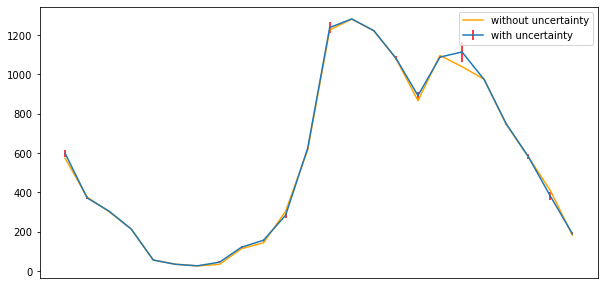

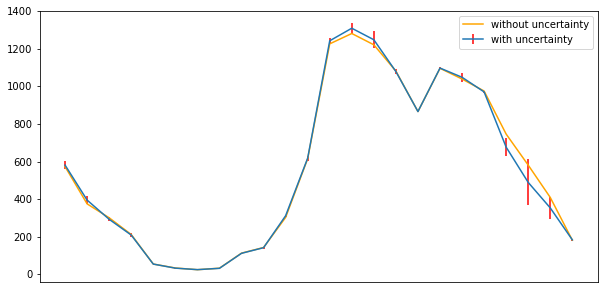

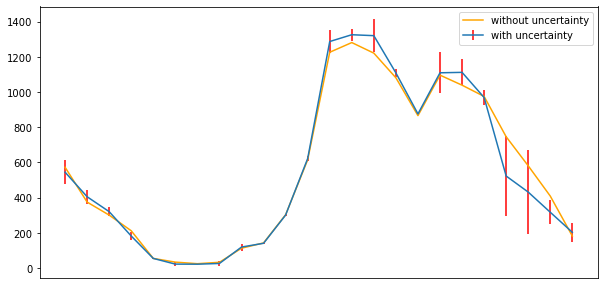

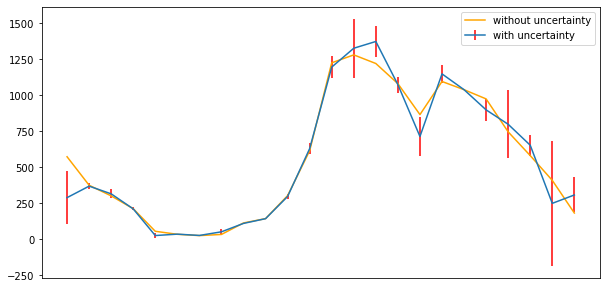

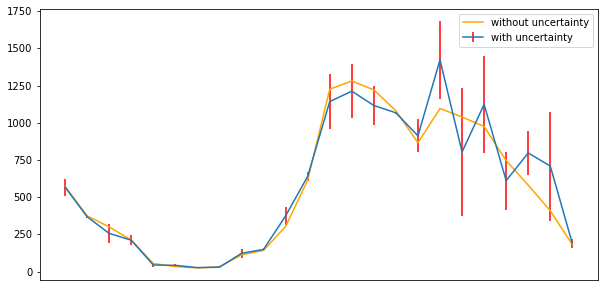

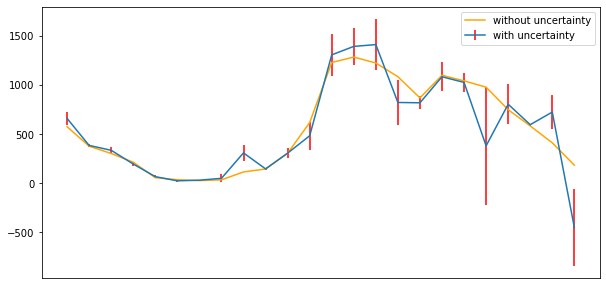

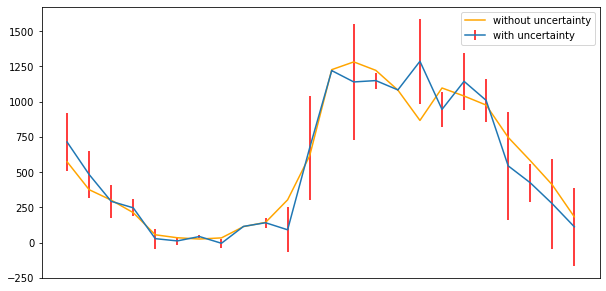

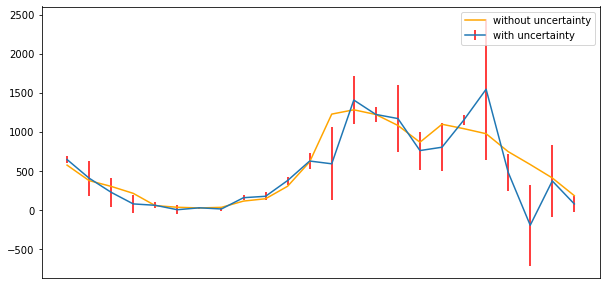

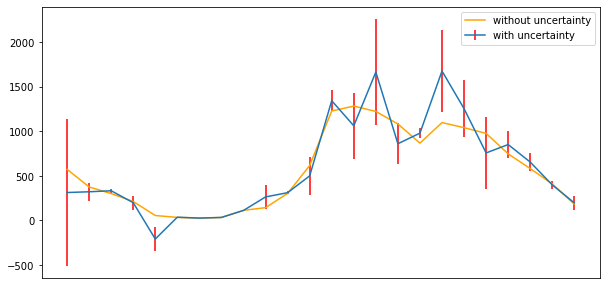

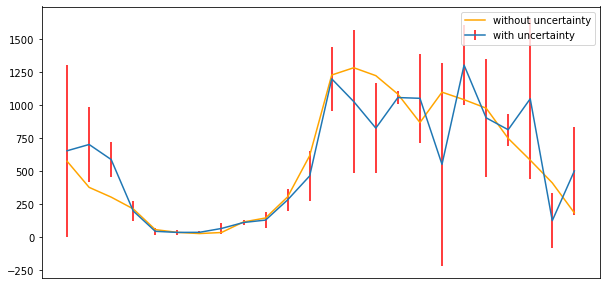

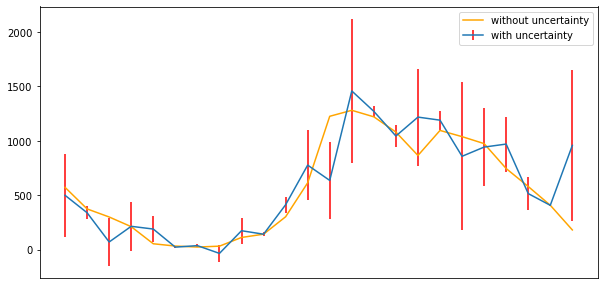

In [77]:
std_coefs = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
name = "Chinatown"
d_train = load_data(name, 'TRAIN')
for std_coef in std_coefs:
    d_train_noised, noise_std = add_noise(d_train, std_coef=std_coef)
    plt.figure(figsize=(10, 5))
    d_train_noised.iloc[0][:-1].plot(label="with uncertainty", xticks=[], yerr=noise_std.iloc[0].values, ecolor='red')
    d_train.iloc[0][:-1].plot(label="without uncertainty", xticks=[], color='orange')
    plt.legend()
    plt.savefig(fname=f"images/uncertain-{name}-{str(std_coef).replace('.', '')}.png")

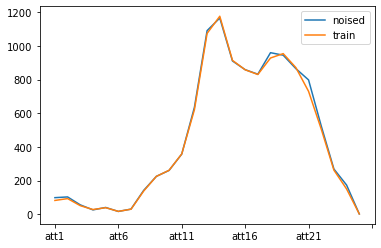

In [36]:
d_train_noised.iloc[-1].plot(label="noised")
d_train.iloc[-1].plot(label="train")
plt.legend()